In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from hpa_src.config import get_data_dir, name_label_dict
from hpa_src.data.datasets import readimg, HpaDataset, TestDataset#, train_val_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline 

In [3]:
DATA = get_data_dir()

In [4]:
image_df = pd.read_csv(DATA + "raw/png/train.csv")

In [5]:
image_df['target_list'] = image_df['Target'].map(lambda x: [int(a) for a in x.split(' ')])

In [6]:
import itertools
all_labels = np.array(list(itertools.chain(*image_df.target_list.values)))

class_n = np.unique(all_labels, return_counts=True)[1]

alpha = class_n / sum(class_n)

image_df = image_df.drop(['target_list'], axis=1)

In [7]:
# # This code only run once
# train_indx, val_indx = train_test_split(np.arange(image_df.shape[0]), test_size=0.2)

# training = image_df.iloc[train_indx].reset_index(drop=True)
# validation = image_df.iloc[val_indx].reset_index(drop=True)

# training.to_csv(DATA+'raw/png/training.csv')
# validation.to_csv(DATA+'raw/png/validation.csv')

In [8]:
# alpha = torch.from_numpy(alpha).float()

# alpha = alpha.cuda()

# alpha.cuda(alpha.device)

# Build Model

In [9]:
from torch.utils.data import DataLoader, random_split
from PIL import Image
from torchvision import transforms
from hpa_src.data.transforms import ToPIL
from torch.nn import BCEWithLogitsLoss
from hpa_src.models.loss import FocalLoss
import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

In [10]:
input_size = 299
train_transform = transforms.Compose([
    ToPIL(),
    #transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.1149, 0.0922, 0.0553),
                         (0.1694, 0.1381, 0.1551))
])
val_transform = transforms.Compose([
    ToPIL(),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize((0.1149, 0.0922, 0.0553),
                         (0.1694, 0.1381, 0.1551))
])

In [11]:
# train_sampler, val_sampler = train_val_split(image_df.shape[0])
# train_sampler, val_sampler = train_val_split(100)

In [12]:
train_dataset = HpaDataset(DATA + 'raw/png/training.csv', transform=train_transform)
val_dataset = HpaDataset(DATA + 'raw/png/validation.csv', transform=val_transform)

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, #sampler=train_sampler,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, #sampler=val_sampler,
    num_workers=16
)

dataloaders = {'train': train_loader, 'val': val_loader}

## Model

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import pretrainedmodels
pretrained = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=1000, pretrained='imagenet')

In [15]:
from torch import nn
class TransferedModel(nn.Module):
    
    def __init__(self,
                 pretrained,
                 num_classes):
        super(TransferedModel, self).__init__()
        self.pretrained = pretrained
        n_feature = pretrained.last_linear.in_features
        self.classifier = nn.Sequential(
            #nn.Linear(n_feature, n_feature),
            #nn.BatchNorm1d(n_feature),
            #nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(n_feature, num_classes))
        self.pretrained.last_linear = self.classifier
    
    def forward(self, x):
        x = self.pretrained(x)
        return x
        
#             nn.Conv2d(n_feature, n_feature, 1),
#             nn.ReLU(inplace=True),

In [ ]:
model = TransferedModel(pretrained, 28)
model = nn.DataParallel(model)

/opt/modules/i12g/anaconda/3-5.0.1/envs/hpaic/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [ ]:
# pretrained = nn.DataParallel(pretrained, device_ids=[1])
# pretrained = pretrained.to(device)

In [ ]:
# criterion = BCEWithLogitsLoss()
criterion = FocalLoss(gamma=2, logits=True)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# dataset_sizes = {'train': len(train_indx), 'val': len(val_indx)}

In [ ]:
# tmp = next(iter(dataloaders['train']))
# pretrained(tmp[0].to_device())

In [ ]:
from hpa_src.models.training import ModelTrainer
from hpa_src.models.callbacks import TorchModelCheckpoint

Using TensorFlow backend.


In [ ]:
trainer = ModelTrainer(model)

In [ ]:
trainer.compile(optimizer_ft, criterion, device='cuda:0')

In [ ]:
checker = TorchModelCheckpoint('../models/torch_trained', monitor='val_f1', save_best_only=True, mode='max')

## First train classifier layer

In [ ]:
from keras.callbacks import History

In [ ]:
for p in trainer.model.parameters():
    p.requires_grad = False
for p in trainer.model.module.classifier.parameters():
    p.requires_grad = True

In [ ]:
trainer.fit(dataloaders['train'], dataloaders['val'], epochs=3)

In [ ]:
for p in trainer.model.parameters():
    p.requires_grad = True

In [ ]:
trainer.fit(dataloaders['train'], dataloaders['val'], epochs=60, model_checker = checker)

In [ ]:
# plt.subplot(121)
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax1.plot(trainer.history.epoch, trainer.history.history['train_loss'], label='train_loss')
ax1.plot(trainer.history.epoch, trainer.history.history['val_loss'], label='val_loss')
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(trainer.history.epoch, trainer.history.history['train_f1'], label='train_f1')
ax2.plot(trainer.history.epoch, trainer.history.history['val_f1'], label='val_f1')
ax2.legend()
plt.savefig('lr0.0005_focal.png')
plt.show()

## Cross validate threshold

In [23]:
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048*2, rlimit[1]))

In [16]:
model = torch.load("../models/torch_trained")

In [17]:
model = model.eval()

In [18]:
all_dataset = HpaDataset(DATA + 'raw/png/train.csv', transform=val_transform)

In [19]:
all_loader = torch.utils.data.DataLoader(
    all_dataset, batch_size=16, #sampler=val_sampler,
    num_workers=16
)

In [ ]:
with torch.no_grad():
    val_preds = []
    val_true = []
    for inputs, labels in all_loader:
        inputs = inputs.to(device)
        val_preds.append(model(inputs))
        val_true.append(labels)

In [25]:
val_preds = torch.cat(val_preds)

In [26]:
val_true = torch.cat(val_true)

In [27]:
from hpa_src.data.functional import preds2label, preds2onehot, array2str
from sklearn.metrics import f1_score

In [28]:
scores = []
for p in np.arange(0.1,0.9,0.02):
    #tmp = preds2onehot(val_preds, threshold=np.log(p/(1-p)))
    scores.append(f1_score(val_true, val_preds>np.log(p/(1-p)), average='macro'))

/opt/modules/i12g/anaconda/3-5.0.1/envs/hpaic/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


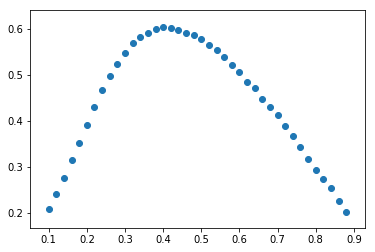

In [29]:
plt.scatter(np.arange(0.1,0.9,0.02), scores)
plt.show()

In [32]:
p_opt = np.arange(0.1,0.9,0.02)[np.argmax(scores)]

In [33]:
p_opt

0.4

### Optimize per class threshold

In [34]:
from hpa_src.data.functional import apply_threshold, optim_threshold

In [35]:
thresholds = []
for i in range(val_true.shape[1]):
    thresholds.append(optim_threshold(val_true[:,i], val_preds[:,i], logits=True))

/opt/modules/i12g/anaconda/3-5.0.1/envs/hpaic/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
tmp = np.stack([val_preds[:,i] > thresholds[i] for i in range(val_preds.shape[1])]).T

In [37]:
f1_score(val_true, tmp, average='macro')

0.6205644298109639

## Test prediction

In [38]:
test = TestDataset(DATA + 'raw/sample_submission.csv', transform=train_transform)

In [39]:
test_dl = DataLoader(test, batch_size=16, num_workers=16)

In [ ]:
with torch.no_grad():
    prediction = [model(img.to(device)) for img in test_dl]
    prediction = torch.cat(prediction)
#     prediction = preds2label(prediction)

In [41]:
preds = list(array2str(apply_threshold(prediction, thresholds)))

In [42]:
# p = np.arange(0.1,0.9,0.02)[np.argmax(scores)]
# p = p_opt
# # p = 0.3
# preds = preds2label(prediction, threshold=np.log(p/(1-p)), fill_na=False)
# preds = list(array2str(preds))

In [44]:
tst = pd.read_csv(DATA + "raw/sample_submission.csv")

In [45]:
tst.Predicted = preds

In [46]:
tst.to_csv(DATA + "processed/Submission.csv", index=False)

In [47]:
tst.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25


In [49]:
torch.sigmoid(torch.tensor(thresholds))

tensor([0.5000, 0.4900, 0.5100, 0.4200, 0.4400, 0.4500, 0.4000, 0.4500, 0.3800,
        0.3900, 0.3900, 0.4200, 0.4200, 0.5600, 0.5900, 0.4400, 0.4000, 0.4300,
        0.3600, 0.4100, 0.3100, 0.4200, 0.4800, 0.4400, 0.4300, 0.4300, 0.4100,
        0.3700])

## Visualize performance

In [53]:
from sklearn.metrics import precision_recall_curve

In [51]:
val_pred_prob = torch.sigmoid(val_preds)

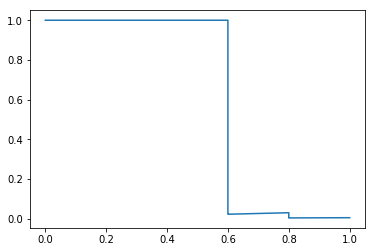

In [84]:
i = 15
prec, rec, _ = precision_recall_curve(val_true[:,i], val_pred_prob[:,i])

plt.plot(rec, prec)
plt.show()

# ignite

In [ ]:
#best_model = train_model(pretrained, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import CategoricalAccuracy, Loss
from ignite.handlers import EarlyStopping

In [ ]:
from hpa_src.models.metrics import F1Score

In [ ]:
trainer = create_supervised_trainer(pretrained, optimizer_ft, criterion, device=device)

In [ ]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

In [ ]:
f1score = F1Score()
handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)

In [ ]:
evaluator = create_supervised_evaluator(pretrained,
                                        metrics={
                                            'loss': Loss(criterion),
                                            'f1': F1Score()
                                        }, device=device)

In [ ]:
evaluator.add_event_handler(Events.COMPLETED, handler)

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print("Training Results - Epoch: {}  Avg loss: {:.2f} Avg f1: {:.2f}"
          .format(trainer.state.epoch, metrics['loss'], metrics['f1']))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg loss: {:.2f} Avg f1: {:.2f}"
          .format(trainer.state.epoch, metrics['loss'], metrics['f1']))

In [ ]:
trainer.run(train_loader, max_epochs=100)

In [ ]:
torch.save(pretrained.state_dict(), DATA + '../models/torch_3epoch')

In [85]:
evaluator.state.metrics

{'loss': 2.5641331955440414, 'f1': 0.24967516695377992}